In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense,\
                         BatchNormalization, Flatten, Reshape, Concatenate, concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\11068\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
dj = pd.read_csv("DowJones.csv")
news = pd.read_csv("News.csv")

In [4]:
dj.isnull().sum()
news.isnull().sum()
print(dj.shape)
print(news.shape)
print(len(set(dj.Date)))
print(len(set(news.Date)))

(1989, 7)
(73608, 2)
1989
2943


In [5]:
'''because the news contains more days than Dow (weekends), we need to delete all the useless news'''
news = news[news.Date.isin(dj.Date)]
print(news.shape)
print(len(set(news.Date)))

(49718, 2)
1989


In [6]:
'''calculate the difference between the next opening and todays, which we believe has relations with the news today'''
dj = dj.set_index('Date').diff(periods = 1)
dj['Date'] = dj.index
dj = dj.reset_index(drop=True)
# Remove unneeded features
dj = dj.drop(['High','Low','Close','Volume','Adj Close'], 1)
dj.head()

,Open,Date
0,NaN,2016-07-01
1,-211.480468,2016-06-30
2,-256.740235,2016-06-29
3,-265.509765,2016-06-28
4,164.701172,2016-06-27


In [7]:
'''Remove the row if it has a null value.'''
dj = dj[dj.Open.notnull()]
print(dj.shape)

(1988, 2)


In [8]:
# Create a list of the opening prices and their corresponding daily headlines from the news
price = []
headlines = []

for row in dj.iterrows():
    daily_headlines = []
    date = row[1]['Date']
    price.append(row[1]['Open'])
    for row_ in news[news.Date == date].iterrows():
        daily_headlines.append(row_[1]['News'])
    headlines.append(daily_headlines)


In [9]:
'''A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python'''
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [10]:
'''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
def clean_text(text, remove_stopwords = True):
    #1. convert words to lower case
    text = text.lower()
    
    #2. replace contractions with their longer forms
    words = text.split()
    new_text = []
    for word in words:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)
    
    #3. format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    #4. Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
        
    return text

In [11]:
#cleaned headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [12]:
clean_headlines[0]

['jamaica proposes marijuana dispensers tourists airports following legalisation kiosks desks would give people license purchase 2 ounces drug use stay',
 'stephen hawking says pollution stupidity still biggest threats mankind certainly become less greedy less stupid treatment environment past decade',
 'boris johnson says run tory party leadership',
 'six gay men ivory coast abused forced flee homes pictured signing condolence book victims recent attack gay nightclub florida',
 'switzerland denies citizenship muslim immigrant girls refused swim boys report',
 'palestinian terrorist stabs israeli teen girl death bedroom',
 'puerto rico default $ 1 billion debt friday',
 'republic ireland fans awarded medal sportsmanship paris mayor',
 'afghan suicide bomber kills 40 bbc news',
 'us airstrikes kill least 250 isis fighters convoy outside fallujah official says',
 'turkish cop took istanbul gunman hailed hero',
 'cannabis compounds could treat alzheimer removing plaque forming proteins br

In [13]:
'''find the number of times each word was used and the size of the vocabulary'''
word_counts = {}

for headlines_daily in clean_headlines:
    for headline in headlines_daily:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
                
print(len(word_counts))


35190


In [14]:
'''load GloVe embeddings'''
embeddings_index = {}
with open('./glove.840B.300d/glove.840B.300d.txt', encoding = 'utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = embedding
    
    print(len(embeddings_index))

2196017


In [15]:
'''# Find the number of words that are missing from GloVe, and are used more than our threshold.'''
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1

print(missing_words)



47


In [16]:
'''limit the vocab that we will use to words that appear >= threshold
or are in Glove'''
#dictionary to convert words to integers
vocab_to_int = {}

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1
#special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>"]

#add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# dictionary to convert integer to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word
    
usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

Total Number of Unique Words: 35190
Number of Words we will use: 31265
Percent of Words we will use: 88.85%


In [17]:
#Need to use 300 for embedding dimensions to match GloVe's vectors
embedding_dim = 300

nb_words = len(vocab_to_int)
#create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words,embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        #if word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0,1.0,embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding
        
        #check if value
print(len(word_embedding_matrix))

31265


In [18]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

int_headlines = []

for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 615989
Total number of UNKs in headlines: 5262
Percent of words that are UNK: 0.8500000000000001%


In [19]:
# Find the length of headlines
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])
lengths.describe()

,counts
count,49693.000000
mean,12.395891
std,6.790246
min,1.000000
25%,7.000000
50%,10.000000
75%,16.000000
max,41.000000


In [20]:
'''Limit the length of a day's news to 200 words, and the length of any headline to 16 words.
   These values are chosen to not have an excessively long training time and 
   balance the number of headlines used and the number of words from each headline.'''
max_headline_length = 16
max_daily_length = 200
pad_headlines = []
    
for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length  
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [21]:
# Normalize opening prices (target values)
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))

In [22]:
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [23]:
# Check that normalization worked well
print(min(norm_price))
print(max(norm_price))
print(np.mean(norm_price))

0.0
1.0
0.5448422454901358


In [24]:
# Split data into training and testing sets.
# Validating data will be created during training.
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [25]:
# Check the lengths
print(len(x_train))
print(len(x_test))

1689
299


In [26]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed= 2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True
if wider == True:
    nb_filter *= 2
    rnn_output_size *= 2
    hidden_dims *= 2
    
model1_input = Input(shape = (max_daily_length, ))
x1 = Embedding(nb_words, 
                         embedding_dim, 
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length)(model1_input)

x1 = Dropout(dropout)(x1)
x1 = Convolution1D(filters=nb_filter,
                             kernel_size = filter_length1, 
                             padding='same', 
                             activation='relu')(x1)
x1 = Dropout(dropout)(x1)
if deeper == True:
    x1 = Convolution1D(filters = nb_filter,
                                 kernel_size = filter_length1, 
                                 padding='same', 
                                 activation='relu')(x1)
    x1 = Dropout(dropout)(x1)    
model1_output = LSTM(rnn_output_size, 
                   activation=None,
                   kernel_initializer=weights,
                   dropout = dropout)(x1)
model1 = Model(inputs = model1_input, outputs = model1_output)

#########################
model2_input = Input(shape = (max_daily_length, ))
x2 = Embedding(nb_words, 
                         embedding_dim, 
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length)(model2_input)

x2 = Dropout(dropout)(x2)
x2 = Convolution1D(filters=nb_filter,
                             kernel_size = filter_length2, 
                             padding='same', 
                             activation='relu')(x2)
x2 = Dropout(dropout)(x2)
if deeper == True:
    x2 = Convolution1D(filters = nb_filter,
                                 kernel_size = filter_length2, 
                                 padding='same', 
                                 activation='relu')(x2)
    x2 = Dropout(dropout)(x2)    
model2_output = LSTM(rnn_output_size, 
                   activation=None,
                   kernel_initializer=weights,
                   dropout = dropout)(x2)
model2 = Model(inputs = model2_input, outputs = model2_output)

####################
concatenated = concatenate([model1_output, model2_output])
x = Dense(hidden_dims, kernel_initializer=weights)(concatenated)
x = Dropout(dropout)(x)
if deeper == True:
    x = Dense(hidden_dims//2, kernel_initializer=weights)(x)
    x = Dropout(dropout)(x)
    
output = Dense(1, kernel_initializer = weights, name='output')(x)
model = Model([model1_input, model2_input], output)
model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate,clipvalue=1.0))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed= 2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True

if wider == True:
    nb_filter *= 2
    rnn_output_size *= 2
    hidden_dims *= 2
    
'''Due to the updating of Keras, change the Sequential model to Functional model'''
def build_model():

    '''
    1. add model a dense (output_size, input_size) and for second_layer(output_size)
    2. Embedding: Turns positive integers (indexes) into
       dense vectors of fixed size. eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
       eg:  model.add(Embedding(1000, 64, input_length=10))
            the model will take as input an integer matrix of size (batch, input_length).
            the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
            now model.output_shape == (None, 10, 64), where None is the batch dimension.
    ''' 
    model1_input = Input(shape = (max_daily_length, ))
    x1 = Embedding(nb_words, 
                         embedding_dim, 
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length)(model1_input)
    # input / output is (batch_dim, max_daily_length, embedding_dim) with no larger than nb_words

    x1 = Dropout(dropout)(x1)
    # add dropout
    x1 = Convolution1D(filters=nb_filter,
                             kernel_size = filter_length1, 
                             padding='same', 
                             activation='relu')(x1)
    # "same" results in padding the input such that the output has the same length as the original input
    x1 = Dropout(dropout)(x1)
    
    if deeper == True:
        x1 = Convolution1D(filters = nb_filter,
                                 kernel_size = filter_length1, 
                                 padding='same', 
                                 activation='relu')(x1)
        x1 = Dropout(dropout)(x1)    
    model1_output = LSTM(rnn_output_size, 
                   activation=None,
                   kernel_initializer=weights,
                   dropout = dropout)(x1)
    model1 = Model(inputs = model1_input, outputs = model1_output)
    # LSTM's output size is rnn_output_size
    ######################################################
    model2_input = Input(shape = (max_daily_length, ))
    x2 = Embedding(nb_words, 
                         embedding_dim, 
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length)(model2_input)

    x2 = Dropout(dropout)(x2)
    x2 = Convolution1D(filters=nb_filter,
                             kernel_size = filter_length2, 
                             padding='same', 
                             activation='relu')(x2)
    x2 = Dropout(dropout)(x2)
    if deeper == True:
        x2 = Convolution1D(filters = nb_filter,
                                 kernel_size = filter_length2, 
                                 padding='same', 
                                 activation='relu')(x2)
        x2 = Dropout(dropout)(x2)    
    model2_output = LSTM(rnn_output_size, 
                   activation=None,
                   kernel_initializer=weights,
                   dropout = dropout)(x2)
    model2 = Model(inputs = model2_input, outputs = model2_output)

    
    #######################################################
    concatenated = concatenate([model1_output, model2_output])
    x = Dense(hidden_dims, kernel_initializer=weights)(concatenated)
    x = Dropout(dropout)(x)
    if deeper == True:
        x = Dense(hidden_dims//2, kernel_initializer=weights)(x)
        x = Dropout(dropout)(x)
    
    output = Dense(1, kernel_initializer = weights, name='output')(x)
    model = Model([model1_input, model2_input], output)
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate,clipvalue=1.0))
    
    return model

In [28]:
# Use grid search to help find a better model
for deeper in [False]:
    for wider in [True,False]:
        for learning_rate in [0.001]:
            for dropout in [0.3, 0.5]:
                model = build_model()
                print()
                print("Current model: Deeper={}, Wider={}, LR={}, Dropout={}".format(
                    deeper,wider,learning_rate,dropout))
                print()
                save_best_weights = 'question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout)

                callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
                             EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

                history = model.fit([x_train,x_train],
                                    y_train,
                                    batch_size=128,
                                    epochs=100,
                                    validation_split=0.15,
                                    verbose=True,
                                    shuffle=True,
                                    callbacks = callbacks)


Current model: Deeper=False, Wider=True, LR=0.001, Dropout=0.3

Instructions for updating:
Use tf.cast instead.
Train on 1435 samples, validate on 254 samples
Epoch 1/100
1435/1435 [==============================] - 19s 13ms/step - loss: 1.4229 - val_loss: 0.0597
Epoch 2/100
1435/1435 [==============================] - 16s 11ms/step - loss: 0.1293 - val_loss: 0.1125
Epoch 3/100
1435/1435 [==============================] - 16s 11ms/step - loss: 0.0621 - val_loss: 0.0262
Epoch 4/100
1435/1435 [==============================] - 16s 11ms/step - loss: 0.0414 - val_loss: 0.0304
Epoch 5/100
1435/1435 [==============================] - 16s 11ms/step - loss: 0.0313 - val_loss: 0.0310
Epoch 6/100
1435/1435 [==============================] - 16s 11ms/step - loss: 0.0266 - val_loss: 0.0209
Epoch 7/100
1435/1435 [==============================] - 16s 11ms/step - loss: 0.0251 - val_loss: 0.0209
Epoch 8/100
1435/1435 [==============================] - 16s 11ms/step - loss: 0.0217 - val_loss: 0.0198



Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/100
1435/1435 [==============================] - 17s 12ms/step - loss: 0.0973 - val_loss: 0.0518
Epoch 6/100
1435/1435 [==============================] - 19s 14ms/step - loss: 0.0945 - val_loss: 0.0507
Epoch 00006: early stopping


In [30]:
# Make predictions with the best weights
deeper=False
wider=False
dropout=0.3
learning_Rate = 0.001
# Need to rebuild model in case it is different from the model that was trained most recently.
model = build_model()

model.load_weights('./question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout))
predictions = model.predict([x_test,x_test], verbose = True)

299/299 [==============================] - 2s 6ms/step


In [31]:
# Compare testing loss to training and validating loss
mse(y_test, predictions)

0.007516746234150936

In [32]:
def unnormalize(price):
    '''Revert values to their unnormalized amounts'''
    price = price*(max_price-min_price)+min_price
    return(price)

In [33]:
unnorm_predictions = []
for pred in predictions:
    unnorm_predictions.append(unnormalize(pred))
    
unnorm_y_test = []
for y in y_test:
    unnorm_y_test.append(unnormalize(y))

In [34]:
# Calculate the median absolute error for the predictions
mae(unnorm_y_test, unnorm_predictions)

77.23565630078338

In [35]:
print("Summary of actual opening price changes")
print(pd.DataFrame(unnorm_y_test, columns=[""]).describe())
print()
print("Summary of predicted opening price changes")
print(pd.DataFrame(unnorm_predictions, columns=[""]).describe())

Summary of actual opening price changes
                 
count  299.000000
mean    -7.094101
std    139.532324
min   -541.050782
25%    -87.465332
50%    -10.759766
75%     54.689941
max    673.139648

Summary of predicted opening price changes
                 
count  299.000000
mean   -44.302160
std     37.702017
min   -189.971313
25%    -67.960205
50%    -45.891479
75%    -22.679565
max     83.493225


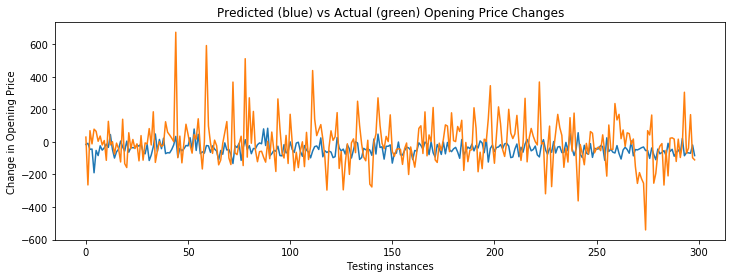

In [36]:
# Plot the predicted (blue) and actual (green) values
plt.figure(figsize=(12,4))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test)
plt.title("Predicted (blue) vs Actual (green) Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()

In [37]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [38]:
# Calculate if the predicted direction matched the actual direction
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))

Predicted values matched the actual direction 55.52% of the time.


In [39]:
def news_to_int(news):
    '''Convert your created news into integers'''
    ints = []
    for word in news.split():
        if word in vocab_to_int:
            ints.append(vocab_to_int[word])
        else:
            ints.append(vocab_to_int['<UNK>'])
    return ints

In [40]:
def padding_news(news):
    '''Adjusts the length of your created news to fit the model's input values.'''
    padded_news = news
    if len(padded_news) < max_daily_length:
        for i in range(max_daily_length-len(padded_news)):
            padded_news.append(vocab_to_int["<PAD>"])
    elif len(padded_news) > max_daily_length:
        padded_news = padded_news[:max_daily_length]
    return padded_news

In [41]:
# Default news that you can use
create_news = "Leaked document reveals Facebook conducted research to target emotionally vulnerable and insecure youth. \
               Woman says note from Chinese 'prisoner' was hidden in new purse. \
               21,000 AT&T workers poised for Monday strike \
               housands march against Trump climate policies in D.C., across USA \
               Kentucky judge won't hear gay adoptions because it's not in the child's \"best interest\" \
               Multiple victims shot in UTC area apartment complex \
               Drones Lead Police to Illegal Dumping in Riverside County | NBC Southern California \
               An 86-year-old Californian woman has died trying to fight a man who was allegedly sexually assaulting her 61-year-old friend. \
               Fyre Festival Named in $5Million+ Lawsuit after Stranding Festival-Goers on Island with Little Food, No Security. \
               The \"Greatest Show on Earth\" folds its tent for good \
               U.S.-led fight on ISIS have killed 352 civilians: Pentagon \
               Woman offers undercover officer sex for $25 and some Chicken McNuggets \
               Ohio bridge refuses to fall down after three implosion attempts \
               Jersey Shore MIT grad dies in prank falling from library dome \
               New York graffiti artists claim McDonald's stole work for latest burger campaign \
               SpaceX to launch secretive satellite for U.S. intelligence agency \
               Severe Storms Leave a Trail of Death and Destruction Through the U.S. \
               Hamas thanks N. Korea for its support against ‘Israeli occupation’ \
               Baker Police officer arrested for allegedly covering up details in shots fired investigation \
               Miami doctor’s call to broker during baby’s delivery leads to $33.8 million judgment \
               Minnesota man gets 15 years for shooting 5 Black Lives Matter protesters \
               South Australian woman facing possible 25 years in Colombian prison for drug trafficking \
               The Latest: Deal reached on funding government through Sept. \
               Russia flaunts Arctic expansion with new military bases"

clean_news = clean_text(create_news)

int_news = news_to_int(clean_news)

pad_news = padding_news(int_news)

pad_news = np.array(pad_news).reshape((1,-1))

pred = model.predict([pad_news,pad_news])

price_change = unnormalize(pred)

print("The Dow should open: {} from the previous open.".format(np.round(price_change[0][0],2)))

The Dow should open: -34.11000061035156 from the previous open.
